# Viewing an ABI band

Without downloading the data from the cloud. All processing is done on Amazon Web Services.

This code is inspired by Amy Huff and by Mya Sears: 
* https://github.com/modern-tools-workshop/AMS-python-workshop-2023/blob/main/download_satellite_data.ipynb
* https://gitlab.cicsnc.org/workshop-development/ams-short-course/-/blob/main/course_materials/02_GOES_aws_classroom.ipynb?ref_type=head


In [1]:
#---Cloud search libraries
import s3fs
import requests
from pathlib import Path
import fnmatch

#---Data libraries
import xarray as xr
import netCDF4
import numpy as np
import datetime

#---Plotting libraries
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

**Hooking up the AWS S3 buckets:**

In [2]:
fs = s3fs.S3FileSystem(anon=True)

**Viewing the products available:**

In [3]:
bucket = 'noaa-goes16'

products_path = bucket

products = fs.ls(products_path)

for product in products:
    print(product.split('/')[-1])

ABI-L1b-RadC
ABI-L1b-RadF
ABI-L1b-RadM
ABI-L2-ACHA2KMC
ABI-L2-ACHA2KMF
ABI-L2-ACHA2KMM
ABI-L2-ACHAC
ABI-L2-ACHAF
ABI-L2-ACHAM
ABI-L2-ACHP2KMC
ABI-L2-ACHP2KMF
ABI-L2-ACHP2KMM
ABI-L2-ACHTF
ABI-L2-ACHTM
ABI-L2-ACMC
ABI-L2-ACMF
ABI-L2-ACMM
ABI-L2-ACTPC
ABI-L2-ACTPF
ABI-L2-ACTPM
ABI-L2-ADPC
ABI-L2-ADPF
ABI-L2-ADPM
ABI-L2-AICEF
ABI-L2-AITAF
ABI-L2-AODC
ABI-L2-AODF
ABI-L2-BRFC
ABI-L2-BRFF
ABI-L2-BRFM
ABI-L2-CCLC
ABI-L2-CCLF
ABI-L2-CCLM
ABI-L2-CMIPC
ABI-L2-CMIPF
ABI-L2-CMIPM
ABI-L2-COD2KMF
ABI-L2-CODC
ABI-L2-CODF
ABI-L2-CPSC
ABI-L2-CPSF
ABI-L2-CPSM
ABI-L2-CTPC
ABI-L2-CTPF
ABI-L2-DMWC
ABI-L2-DMWF
ABI-L2-DMWM
ABI-L2-DMWVC
ABI-L2-DMWVF
ABI-L2-DMWVM
ABI-L2-DSIC
ABI-L2-DSIF
ABI-L2-DSIM
ABI-L2-DSRC
ABI-L2-DSRF
ABI-L2-DSRM
ABI-L2-FDCC
ABI-L2-FDCF
ABI-L2-FDCM
ABI-L2-FSCC
ABI-L2-FSCF
ABI-L2-FSCM
ABI-L2-LSAC
ABI-L2-LSAF
ABI-L2-LSAM
ABI-L2-LST2KMF
ABI-L2-LSTC
ABI-L2-LSTF
ABI-L2-LSTM
ABI-L2-LVMPC
ABI-L2-LVMPF
ABI-L2-LVMPM
ABI-L2-LVTPC
ABI-L2-LVTPF
ABI-L2-LVTPM
ABI-L2-MCMIPC
ABI-L2-MCMIPF
ABI-L2-MCMIPM
ABI

**Set the datetime of interest:**

In [4]:
year = 2023
month = 9
day = 7
hour = 0

julian = datetime.datetime(year, month, day).strftime('%j')

**Set the product of interest:**

In [5]:
product = 'ABI-L1b-RadF'

data_path = bucket + '/' + product + '/'  + str(year) + '/' + str(julian).zfill(3) + '/' + str(hour).zfill(2)

files = fs.ls(data_path)

print('Total number of files:', len(files), '\n')

for file in files[:3]:
    print(file.split('/')[-1])
print('...')
for file in files[-3:]:
    print(file.split('/')[-1])

Total number of files: 96 

OR_ABI-L1b-RadF-M6C01_G16_s20232500000203_e20232500009511_c20232500009554.nc
OR_ABI-L1b-RadF-M6C01_G16_s20232500010203_e20232500019511_c20232500019556.nc
OR_ABI-L1b-RadF-M6C01_G16_s20232500020203_e20232500029511_c20232500029565.nc
...
OR_ABI-L1b-RadF-M6C16_G16_s20232500030203_e20232500039523_c20232500039573.nc
OR_ABI-L1b-RadF-M6C16_G16_s20232500040203_e20232500049523_c20232500049551.nc
OR_ABI-L1b-RadF-M6C16_G16_s20232500050203_e20232500059524_c20232500059557.nc


**Set the band of interest:**
* returns the six ten-minute increments within the hour

In [6]:
band = 7
files_band = [file for file in files if fnmatch.fnmatchcase(file.split('/')[-1], "OR_ABI-L1b-RadF-M6C"+str(band).zfill(2)+"*")]

for file in files_band:
    print(file.split('/')[-1])

OR_ABI-L1b-RadF-M6C07_G16_s20232500000203_e20232500009523_c20232500009560.nc
OR_ABI-L1b-RadF-M6C07_G16_s20232500010203_e20232500019523_c20232500019568.nc
OR_ABI-L1b-RadF-M6C07_G16_s20232500020203_e20232500029525_c20232500029569.nc
OR_ABI-L1b-RadF-M6C07_G16_s20232500030203_e20232500039523_c20232500039553.nc
OR_ABI-L1b-RadF-M6C07_G16_s20232500040203_e20232500049523_c20232500049563.nc
OR_ABI-L1b-RadF-M6C07_G16_s20232500050203_e20232500059523_c20232500059570.nc


**Choose the ten-minute window within the hour:**
* ranging from 0 to 5

In [7]:
ten_min_window = 0
file_sel = files_band[ten_min_window]
print('File selected: ', file_sel.split('/')[-1])

File selected:  OR_ABI-L1b-RadF-M6C07_G16_s20232500000203_e20232500009523_c20232500009560.nc


**Get the selected file from AWS (no download):**
* If response is 404, file is missing

In [8]:
resp = requests.get(f'https://'+bucket+'.s3.amazonaws.com/'+file_sel[12:])

In [9]:
resp

<Response [200]>

**Open as a netCDF with xarray:**

In [10]:
nc = netCDF4.Dataset(file_sel, memory = resp.content)

In [11]:
ds = xr.open_dataset(xr.backends.NetCDF4DataStore(nc))

**Functions to add latitude and longitude:**

In [12]:
def calc_latlon(ds):
    # The math for this function was taken from 
    # https://makersportal.com/blog/2018/11/25/goes-r-satellite-latitude-and-longitude-grid-projection-algorithm
    x = ds.x
    y = ds.y
    goes_imager_projection = ds.goes_imager_projection
    
    x,y = np.meshgrid(x,y)
    
    r_eq = goes_imager_projection.attrs["semi_major_axis"]
    r_pol = goes_imager_projection.attrs["semi_minor_axis"]
    l_0 = goes_imager_projection.attrs["longitude_of_projection_origin"] * (np.pi/180)
    h_sat = goes_imager_projection.attrs["perspective_point_height"]
    H = r_eq + h_sat
    
    a = np.sin(x)**2 + (np.cos(x)**2 * (np.cos(y)**2 + (r_eq**2 / r_pol**2) * np.sin(y)**2))
    b = -2 * H * np.cos(x) * np.cos(y)
    c = H**2 - r_eq**2
    
    #--- Added absolute to remove error
    r_s = (-b - np.sqrt(np.absolute(b**2 - 4*a*c)))/(2*a)
    
    s_x = r_s * np.cos(x) * np.cos(y)
    s_y = -r_s * np.sin(x)
    s_z = r_s * np.cos(x) * np.sin(y)
    
    lat = np.arctan((r_eq**2 / r_pol**2) * (s_z / np.sqrt((H-s_x)**2 +s_y**2))) * (180/np.pi)
    lon = (l_0 - np.arctan(s_y / (H-s_x))) * (180/np.pi)
    
    ds = ds.assign_coords({
        "lat":(["y","x"],lat),
        "lon":(["y","x"],lon)
    })
    ds.lat.attrs["units"] = "degrees_north"
    ds.lon.attrs["units"] = "degrees_east"
    return ds



def get_xy_from_latlon(ds, lats, lons):
    lat1, lat2 = lats
    lon1, lon2 = lons

    lat = ds.lat.data
    lon = ds.lon.data
    
    x = ds.x.data
    y = ds.y.data
    
    x,y = np.meshgrid(x,y)
    
    x = x[(lat >= lat1) & (lat <= lat2) & (lon >= lon1) & (lon <= lon2)]
    y = y[(lat >= lat1) & (lat <= lat2) & (lon >= lon1) & (lon <= lon2)] 
    
    return ((min(x), max(x)), (min(y), max(y)))

**Limiting the view to a certain range:**

In [13]:
min_lon = -71.5
min_lat = 38
max_lon = -65
max_lat = 42.5
lats = (min_lat, max_lat)
lons = (min_lon, max_lon)

**Running the lat/lon calculations:**

In [14]:
ds_07 = calc_latlon(ds)

#---This is needed to convert the lat/lon range into the x/y dimensions
#------The dataset will only filter by the official dimensions
((x1,x2), (y1, y2)) = get_xy_from_latlon(ds_07, lats, lons)

In [15]:
subset_07 = ds_07.sel(x=slice(x1, x2), y=slice(y2, y1))

**Getting the wavelength and datetime strings:**

In [23]:
dt_str = np.datetime_as_string(ds_07.t.values, unit='s')
wl = str(ds_07.band_wavelength.values[0])

**Plotting the band image:**

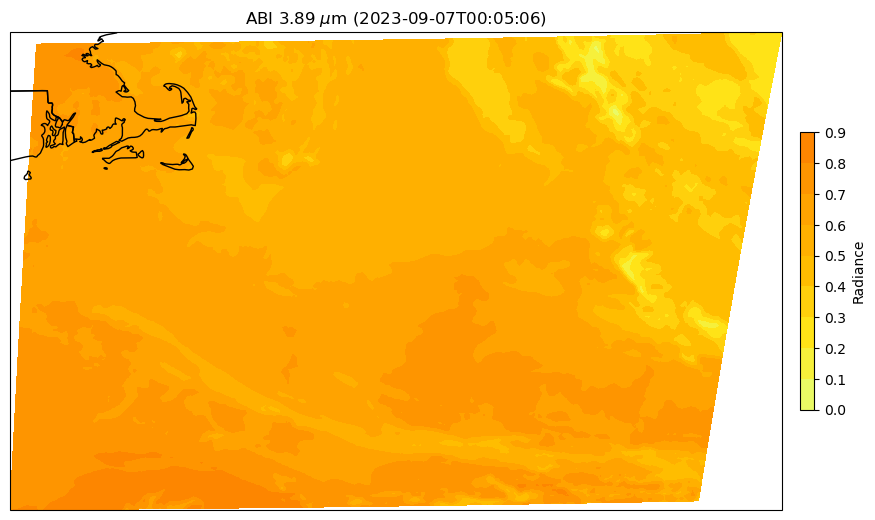

In [24]:
projection=ccrs.PlateCarree()
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.Wistia
#levels=np.linspace(270, 320, 15)

c=ax.contourf(subset_07.lon, subset_07.lat, subset_07.Rad, cmap=cmap)#, levels=levels)
clb=plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('ABI '+wl+' $\mu$m ('+dt_str+')')
clb.set_label('Radiance')

ax.add_feature(cfeature.STATES)